In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 6, 15, 19, 8, 39, 976236)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至.+"))
data

['try { window.getTimelineService1 = [{"id":53981,"pubDate":1592234160000,"pubDateStr":"3小时前","title":"朝阳区所有社区采取二级防控措施，进入疫情防控战时状态","summary":"针对北京市新冠疫情防控出现新变化，朝阳区迅速响应，坚决贯彻落实北京市有关疫情防控工作部署，严格落实“全市所有社区（村）都采取三级应急响应、二级防控措施、一级工作状态”，全区所有社区防控迅速进入疫情防控战时状态，筑牢社区防线，坚决遏制疫情扩散蔓延。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=ArtiXUmxzq0TUQVQrIJ5GA1y200615&isfromapp=1","provinceId":""},{"id":53966,"pubDate":1592230538000,"pubDateStr":"4小时前","title":"四川确诊1例为北京确诊病例密接，此前被诊断为疑似病例","summary":"据四川卫健委官网，6月15日，四川雅安市石棉县报告确诊1例新冠肺炎省外输入性病例。新增的1例新冠肺炎确诊病例6月9日自北京乘海航HU7147航班到成都，然后乘私家车返回雅安市石棉县。","infoSource":"人民日报","sourceUrl":"https://m.weibo.cn/2803301701/4516204565894748","provinceId":""},{"id":53949,"pubDate":1592227944000,"pubDateStr":"5小时前","title":"肯尼亚总统府4人感染新冠病毒","summary":"肯尼亚总统府发言人蒂娜于当地时间6月15日发布消息称，总统府内有4名官员在6月11日的新冠病毒排查检测中确诊，现已就医诊治中。","infoSource":"央视新闻app","sourceUrl":"http://app.cctv.com/special/cportal/detail/arti/index.html?id=Artij2dxFEmAMlR82TVZvd1W

In [7]:
for s in data:
    m = re.search("截至.*(202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-06-15 23:50'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1592236223000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-06-15 23:50,84784,79915,4645


### Save to file

In [11]:
from pathlib import Path
csv_file = '../data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = '../images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-06-15 17:57:00,84780,79913,4645
2020-06-15 19:07:00,84783,79915,4645
2020-06-15 20:53:00,84783,79915,4645


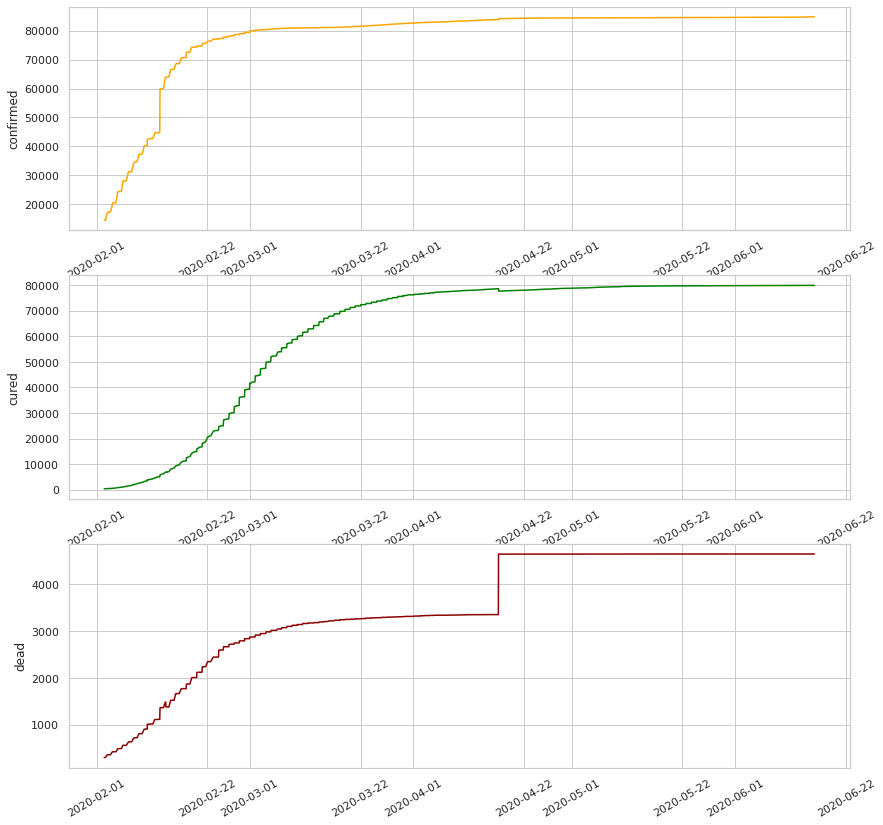

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)